In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

from dechorate import constants
from dechorate.dataset import DechorateDataset, SyntheticDataset
from dechorate.utils.file_utils import save_to_pickle, load_from_pickle, save_to_matlab
from dechorate.utils.dsp_utils import normalize, resample, envelope

from risotto.rtf import estimate_rtf

from brioche.beamformer import DS, MVDR, LCMV
from brioche.utils.dsp_utils import diffuse_noise

/home/ddicarlo/Documents/Code/InProgress/2019@Barilan_dataset_dechorate/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
curr_dir = '../recipes/echo_aware_processing/'
data_filename = curr_dir + 'data_notebook.pkl'

# Get the data: RIRs and Annotation

Surf the dEchorate and load the RIRs and the correspondent annotation

In [4]:
dataset_dir = '../data/dECHORATE/'
path_to_processed = '../data/processed/'
path_to_note_csv = dataset_dir + 'annotations/dECHORATE_database.csv'
path_to_after_calibration = path_to_processed + \
    'post2_calibration/calib_output_mics_srcs_pos.pkl'

# Some constant of the dataset
L = constants['rir_length']
Fs = constants['Fs']
c = constants['speed_of_sound']
L = constants['rir_length']
datasets_name = constants['datasets'][:6]
D = len(datasets_name)

# Annotation, RIRs from measurements, 'equivalent' synthetic RIRs
note_dict = load_from_pickle(path_to_after_calibration)
rdset = DechorateDataset(path_to_processed, path_to_note_csv)
sdset = SyntheticDataset()


In [5]:
# which microphones?
mics_idxs = [15, 16, 17, 18, 19]
I = len(mics_idxs)
# which mic is the reference?
ref_mic = 3 # the third

# which source?
srcs_idxs = [0, 1]
J = len(srcs_idxs)
# which src is the one to enhance?
tgt_src = 0 # the first

# how many echoes to rake?
K = 7
# in which order?
order = 'order' # earliest, strongest, order

In [22]:
rirs_real = np.zeros([L, I, J, D])
rirs_synt = np.zeros([L, I, J, D])
mics = np.zeros([3, I])
srcs = np.zeros([3, J])
toas = np.zeros([K, I, J])
toas_synt = np.zeros_like(toas)
toas_peak = np.zeros_like(toas)

for d, dset in enumerate(datasets_name):
    for i, m in enumerate(mics_idxs):
        for j, s in enumerate(srcs_idxs):

            # get rir from the recondings
            rdset.set_dataset(dset)
            rdset.set_entry(m, s)
            mic, src = rdset.get_mic_and_src_pos()
            _, rrir = rdset.get_rir()

            # measure after calibration
            mics[:, i] = note_dict['mics'][:, m]
            srcs[:, j] = note_dict['srcs'][:, s]

            # get synthetic rir
            sdset = SyntheticDataset()
            sdset.set_room_size(constants['room_size'])
            sdset.set_dataset(dset, absb=0.85, refl=0.15)
            sdset.set_c(c)
            sdset.set_k_order(17)
            sdset.set_mic(mics[0, i], mics[1, i], mics[2, i])
            sdset.set_src(srcs[0, j], srcs[1, j], srcs[2, j])
            # amp, tau, wall, order, gen = sdset.get_note()

            _, srir = sdset.get_rir(normalize=False)
            Ls = len(srir)

            # measure after calibration
            rirs_real[:, i, j, d] = rrir[:L]
            rirs_synt[:Ls, i, j, d] = srir[:Ls]

            toas_synt[:K, i, j] = note_dict['toa_sym'][:K, m, s]
            toas_peak[:K, i, j] = note_dict['toa_pck'][:K, m, s]

print('done with the extraction')
rirs_real = np.squeeze(rirs_real)
rirs_synt = np.squeeze(rirs_synt)

data = {
    'rirs_real' : rirs_real,
    'rirs_synt' : rirs_synt,
    'mics' : mics,
    'srcs' : srcs,
    'toas_synt' : toas_synt,
    'toas_peak' : toas_peak,
}


save_to_pickle(data_filename, data)
print('Saved.')

done with the extraction
Saved.


## Compute amplitudes with Condat's formula

[ 3.74731700e-03 -6.66118495e-05  2.64865424e-05  4.52034036e-04
 -2.87476962e-05  4.70397051e-05 -8.70360709e-05]


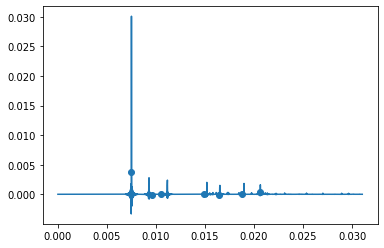

ZeroDivisionError: division by zero

In [82]:
for j in range(J):
    for i in range(I):
        for d in range(D):
            
            tk = toas_synt[:, i, j]
            L = int(np.max(toas_synt[:, i, j])*Fs)+500
            tau = L/Fs
            rir = rirs_synt[:L, i, j, d]
            v = np.fft.fft(rir)
            M = (len(v)-1)/2
            MM = np.arange(-M,M+1)
            assert -MM[0] == MM[-1]
            assert len(MM) == len(v)
            U = np.exp(-1j*2*np.pi*MM[:,None]@tk[None,:]/tau)
            ak = np.real(np.linalg.lstsq(U, v, rcond=None)[0])
            print(ak)
            plt.plot(np.arange(L)/Fs, rir)
            plt.scatter(tk, ak)
            plt.show()
            1/0

ValueError: x and y must be the same size

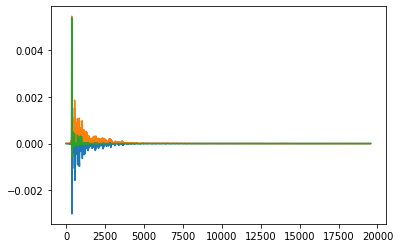

In [23]:
# Plot on sample
i, j, d = (0, 0, 0)

a = np.max(np.abs(rirs_real[:, i, j, d]))
t1  = np.argmax(rirs_synt[:, i, j, d])


plt.plot(rirs_real[:, i, j, d])
plt.plot(envelope(rirs_real[:, i, j, d]))
plt.plot(a * normalize(rirs_synt[:, i, j, d]))
plt.scatter(toas, amps)
plt.xlim(t1 - 30, t1+500)
plt.show()

# Load the Real Data
load samples from the WSJ dataset and convolve in with the rirs

In [11]:
data_dir = curr_dir + 'TIMIT_long_nili/'
s1m = data_dir + 'DR5_MHMG0_SX195_SX285_SX375_7s.wav'
s2m = data_dir + 'DR7_MGAR0_SX312_SX402_7s.wav'
s1f = data_dir + 'DR1_FTBR0_SX201_SI921_7s.wav'
s2f = data_dir + 'DR4_FKLC0_SI985_SI2245_7s.wav'

files = [s1m, s2m, s1f, s2f]
N = len(files)

In [12]:
wavs = []
for file in files:
    wav, fs = sf.read(file)
    assert len(wav.shape) == 1
    wavs.append(wav[:7*fs])
print('done.')
print('Fs wavs is', fs)

done.
Fs wavs is 16000


# Make Audio Scene

In [13]:
d = 0 # first dataset
h_ = rirs_real[:, :, :, d] # real rirs
r = 0 # reference mic
inr = 15 # dB
snr = 20 # dB
sir = snr - inr # dB
print(sir)

5


In [14]:
mic_pos = mics
mic_pos

array([[3.35956993, 3.3818327 , 3.40966117, 3.44583818, 3.50149512],
       [2.40748639, 2.44071843, 2.48225849, 2.53626056, 2.61934068],
       [1.38561103, 1.38561103, 1.38561103, 1.38561103, 1.38561103]])

In [15]:
arr_pos = np.mean(mics, 1)
arr_pos

array([3.41967942, 2.49721291, 1.38561103])

In [16]:
tgt_pos = srcs[:, 0:1]
tgt_pos

array([[1.89407487],
       [4.52190448],
       [1.4481839 ]])

In [17]:
itf_pos = srcs[:, 1:2]
itf_pos

array([[1.6330509 ],
       [0.8420041 ],
       [1.02493109]])

In [ ]:
plt.scatter(mic_pos[0,:], mic_pos[1,:], label='mics')
plt.scatter(tgt_pos[0,:], tgt_pos[1,:], label='target')
plt.scatter(itf_pos[0,:], itf_pos[1,:], label='interferer')
plt.annotate('',
             (arr_pos[0], arr_pos[1]), 
             (tgt_pos[0], tgt_pos[1]),
             arrowprops = {'arrowstyle' : '<-', 
                           'connectionstyle':'arc3',
                           'color': 'C1'})
plt.annotate('', 
             (arr_pos[0], arr_pos[1]), 
             (itf_pos[0], itf_pos[1]),
             arrowprops = {'arrowstyle' : '<-', 
                           'connectionstyle':'arc3',
                           'color': 'C2'})
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.legend()
plt.show()

# Make Mixtures

In [ ]:
s1 = wavs[0]
s2 = wavs[1]

# center and scale for unit variance
ss1 = (s1-np.mean(s1))/np.std(s1)
ss2 = (s2-np.mean(s2))/np.std(s2)
assert len(ss1) == len(ss2)

plt.plot(ss1, label='target')
plt.plot(ss2, label='interf')
plt.legend()
plt.show()

In [ ]:
# Upsampling and stacking
print(fs, '-->', Fs)
s_ = np.concatenate([resample(ss1, fs, Fs)[:, None], 
                     resample(ss2, fs, Fs)[:, None]], axis=1)
print(s_.shape)

Lc = 10*fs
c_ = np.zeros([Lc, I, J])

# Convolution, downsampling and stacking
print(fs, '-->', Fs)
for i in range(I):
    for j in range(J):
        cs = np.convolve(h_[:, i, j], s_[:, j], 'full')
        cs = resample(cs, Fs, fs)
        L = len(cs)
        print(i, j, L)
        c_[:L, i, j] = cs
        
print('Done.')

In [ ]:
plt.plot(c_[:, r, 0], label='target')
plt.plot(c_[:, r, 1], label='interf')
plt.legend()
plt.show()

In [ ]:
# Standardization wtr reference microphone
sigma_target = np.std(c_[:7*fs, r, 0])
sigma_interf = np.std(c_[:7*fs, r, 1])

c_[:, :, 0] = c_[:, :, 0] / sigma_target
c_[:, :, 1] = c_[:, :, 1] / sigma_interf

# hereafter we assume that the two images have unit-variance at the reference microphone

In [ ]:
plt.plot(c_[:, r, 0], label='target')
plt.plot(c_[:, r, 1], label='interf')
plt.legend()
plt.show()

In [ ]:
# lets add some silence and shift the source such that there is overlap
cs1 = np.concatenate([np.zeros([2*fs, I]), c_[:, :, 0], np.zeros([4*fs, I]), np.zeros([2*fs, I])], axis=0)
cs2 = np.concatenate([np.zeros([2*fs, I]), np.zeros([4*fs, I]), c_[:, :, 1], np.zeros([2*fs, I])], axis=0)
# diffuse noise field simulation given the array geometry
dn = diffuse_noise(mic_pos, cs1.shape[0], fs, c=343, N=32, mode='sphere').T
assert dn.shape == cs1.shape
# and unit-variance with respect to the ref mic
dn = dn / np.std(dn[:, r])

In [ ]:
plt.plot(cs1[:, r], label='target')
plt.plot(cs2[:, r], label='interf')
plt.plot(dn[:, r], label='mnoise')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def todB(x):
    return 10*np.log10(x)

In [ ]:
# # proof of the SIR/SNR/INR derivation
# a = np.random.random(L)
# b = np.random.random(L)
# c = np.random.random(L)

# snr = 40
# inr = 2
# sir = snr - inr

# sigma_n = np.sqrt(10 ** (- snr / 10))
# sigma_i = np.sqrt(10 ** (- sir / 10))

# a = (a - np.mean(a))/np.std(a)
# b = sigma_i*(b - np.mean(b))/np.std(b)
# c = sigma_n*(c - np.mean(c))/np.std(c)

# print('SNR', todB(np.var(a)/np.var(c)))
# print('SIR', todB(np.var(a)/np.var(b)))
# print('INR', todB(np.var(b)/np.var(c)))

## Scale according to SNR and INR

In [ ]:
sigma_n = np.sqrt(10 ** (- snr / 10))
sigma_i = np.sqrt(10 ** (- sir / 10))

cs1 = cs1
cdn = sigma_n * dn
cs2 = sigma_i * cs2

In [ ]:
t = np.arange(len(cs1[:, r]))/fs
plt.plot(t, cs1[:, r], label='target')
plt.plot(t, cs2[:, r], label='interf')
plt.plot(t, cdn[:, r], label='mnoise')
plt.legend(loc='upper right')
plt.show()

## Mix all together

In [ ]:
# mixing all together 
x = cs1 + cs2 + cdn
plt.plot(x, label='mix')
plt.legend(loc='upper right')
plt.show()

## VAD for RTF computation

In [ ]:
vad = {
    'target' : (int(2.1*fs), int(3.1*fs)),
    'interf' : (int(2.1*fs), int(3.1*fs)),
    'noise'  : (int(0.5*fs), int(1.5*fs)),
}

x = cs1 + cs2 + cdn

plt.plot(x, label='mix')
plt.legend(loc='upper right')
plt.show()

# Beamforming

In [ ]:
assert fs == 16000
nfft = 1024
hop = 512
nrfft = nfft+1
K = 7

## RTF from data

In [ ]:
RTF = np.zeros([nrfft, I], dtype=np.complex)
RTF[:, r] = np.ones(nrfft)

for src in ['target', 'interf']:
    for i in range(1,I):
        mr = x[vad[src][0]:vad[src][1], r]
        mi = x[vad[src][0]:vad[src][1], i]
        nd = x[vad['noise'][0]:vad['noise'][1], [r, i]]
        RTF[:, i] = estimate_rtf(mi, mr, 'gevdRTF', 'full', Lh=None, n=nd, Fs=fs, nfft=nfft, hop=hop)
        print(i)
print('Done.')
dRTF = RTF.copy()

## RTF from TDOA

### test cadzow rec

In [ ]:
from dechorate.cadzow import amplitudes_from_locations

def H(x):
    return np.conj(x.T)

# test
tk = np.array([[1.4, 45.3, 87.5, 100.4, 184.6, 333.4]])/fs
ak = np.array([[1,   0.63, 0.53, 0.453, 0.345, 0.123]])
tau = 500/fs
M = 512
# observation
MM = np.arange(-M, M+1)[:,None]
v = np.exp(-1j*2*np.pi/tau*MM@tk)@ak.T

plt.plot(MM[:,0], np.abs(v))
plt.show()

In [ ]:
U = np.exp(-1j*2*np.pi/tau*MM@tk)
vobs= v.copy()
akest = np.real(np.linalg.lstsq(U, vobs)[0].T)
print(akest)

In [ ]:
for j in range(J):
    for i in range(I):
        rir = np.abs(h_[:, i, j])
        toa = toas_peak[]

### RTF computation

In [ ]:
RTF = np.zeros([nrfft, I], dtype=np.complex)
RTF[:, r] = np.ones(nrfft)

freqs = np.linspace(0,fs//2,nrfft)
omegas = 2*np.pi*freqs
print(freqs)
print(omegas)

def rake_filter(amp, toa):
    assert len(amp) == len(toa) == 7
    H = amp[:,None] * np.exp(1j*omegas[None, :] * toa[:, None])
    
rake_filter()

In [ ]:
for src in ['target', 'interf']:
    for i in range(1,I):
            
        print(i)
print('Done.')
tRTF = RTF